In [1]:
import os
import json
import h5py
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.optim import Adam 
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from copy import deepcopy
import datetime
import tqdm

import imageio

import sys 
sys.path.append("/home/ns1254/nn_project/gym-pusht/gym_pusht/envs/")
from pusht import *

In [2]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
dataset_path = "/home/ns1254/data_pusht/pusht_demos_50.hdf5" 
f = h5py.File(dataset_path, "r")
demos = list(f["data"].keys())
num_demos = len(demos)
print(f'Number of demos: {num_demos}')

Number of demos: 50


In [4]:
# select_keys=['images', 'states']
select_keys=['states']

In [5]:
actions_list=[]
obs_list=[]
for i,demo_id in enumerate(demos): 
    traj=f['data'][demo_id]

    # actions=traj['actions']
    actions = traj['dactions']
    select_obs=traj['obs']['states'] 
    actions_list.append(actions)
    obs_list.append(select_obs)
    
actions=np.concatenate(actions_list, axis=0)
states=np.concatenate(obs_list, axis=0)

actions.shape, states.shape

((34475, 2), (34475, 5))

In [6]:
data_loader_train = DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True) 

batch=next(iter(data_loader_train))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 5]), torch.Size([64, 2]))

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, layer_dims, action_dim):
        super(MLP, self).__init__()
        self.encoder= nn.ModuleList()
        for i in range(len(layer_dims)):
            if i==0: 
                self.encoder.append(nn.Linear(input_dim, layer_dims[i]))
            else:
                self.encoder.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            self.encoder.append(nn.ReLU())

        self.dropout = nn.Dropout(0.2)
        self.decoder = nn.Linear(layer_dims[-1], action_dim)

    def forward(self,x):
        for module in self.encoder:
            x = module(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x 

In [8]:
learning_rate = 1e-4

state_dim=5
action_dim=2
bc = MLP(state_dim, [64, 32], action_dim).to(device)
criterion = nn.MSELoss() 
optimizer = Adam(bc.parameters(), lr = learning_rate)

In [9]:
loss_list = [] 
n_epoch = 200
losses=[]
losses_valid=[]
for itr in tqdm.tqdm(range(1, n_epoch+1)):
    bc.train()
    train_loss = 0
    b=0
    for batch_states, batch_actions in data_loader_train: 
        batch_states = batch_states.to(device)
        batch_actions = batch_actions.to(device)
        y_pred = bc(batch_states.float())
        loss   = criterion(y_pred, batch_actions.float()) 
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1  
        loss_list.append(loss.item()) 
    
    train_loss=train_loss/b
    losses.append(train_loss)
    
    if itr % (n_epoch//10) == 0:
        print(f'Epoch {itr} Train.Loss: {train_loss:.4f}')

 10%|█         | 20/200 [00:12<01:45,  1.71it/s]

Epoch 20 Train.Loss: 15.3533


 20%|██        | 40/200 [00:24<01:32,  1.73it/s]

Epoch 40 Train.Loss: 14.8575


 30%|███       | 60/200 [00:35<01:21,  1.71it/s]

Epoch 60 Train.Loss: 14.5317


 40%|████      | 80/200 [00:47<01:10,  1.70it/s]

Epoch 80 Train.Loss: 14.2890


 50%|█████     | 100/200 [00:59<00:58,  1.71it/s]

Epoch 100 Train.Loss: 14.1120


 60%|██████    | 120/200 [01:10<00:46,  1.71it/s]

Epoch 120 Train.Loss: 13.9811


 70%|███████   | 140/200 [01:22<00:35,  1.71it/s]

Epoch 140 Train.Loss: 13.8169


 80%|████████  | 160/200 [01:34<00:23,  1.71it/s]

Epoch 160 Train.Loss: 13.7239


 90%|█████████ | 180/200 [01:45<00:11,  1.71it/s]

Epoch 180 Train.Loss: 13.6692


100%|██████████| 200/200 [01:57<00:00,  1.70it/s]

Epoch 200 Train.Loss: 13.6025


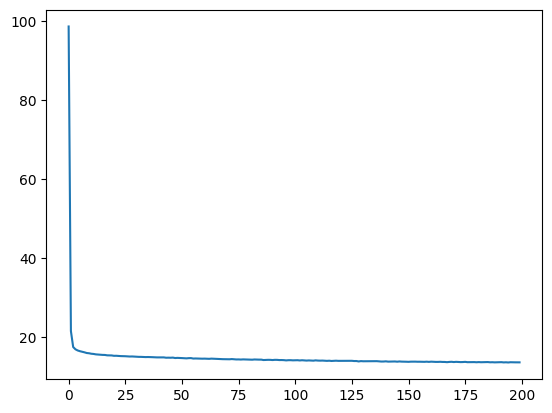

In [10]:
plt.plot(losses)

In [14]:
demo_id = demos[0]
traj=f['data'][demo_id]
actions=traj['dactions']
states=traj['obs']['states']
actions.shape, states.shape

((482, 2), (482, 5))

In [15]:
bc.eval()
states_tensor = torch.tensor(states).float().to(device)
actions_pred = bc(states_tensor).detach().cpu().numpy()

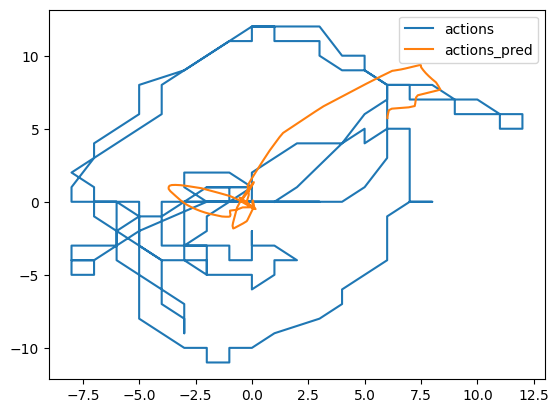

In [16]:
plt.plot(actions[:,0], actions[:,1], label='actions')
plt.plot(actions_pred[:,0], actions_pred[:,1], label='actions_pred')
plt.legend()
plt.show()

In [21]:
env=PushTEnv()

state,info=env.reset()
ax,ay=info['pos_agent']
ax, ay

(55.0, 116.0)

In [22]:
env=PushTEnv()

state,info=env.reset()
ax,ay=info['pos_agent']
 

bc.eval()
max_steps=1000
rewards=[]
rgbs=[]
for i in range(max_steps):
    state_tensor = torch.tensor(state).float().to(device)
    action_pred = bc(state_tensor).detach().cpu().numpy()
    action_pred = action_pred
    action=[ax + action_pred[0] , ay + action_pred[1]]
    state,reward,done,trunc,info=env.step(action_pred)

    ax,ay=info['pos_agent']
    rgb=env.render()
    rgbs.append(rgb)
    rewards.append(reward)
    if done:
        break

print(f"Total reward: {sum(rewards)}")

Total reward: 0.0


In [23]:
imageio.mimsave('bc_pusht.mp4', rgbs, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (680, 680) to (688, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[swscaler @ 0x5709e80] Warning: data is not aligned! This can lead to a speed loss
